# cflowpy - A Python Package for Flow Simulation

- Author: Jan Habscheid
- E-mail: Jan.Habscheid@rwth-aachen.de
- Matriculation number: 418219

This notebook is part of the final submission in the lecture "Sustainable Computational Engineering" at RWTH Aachen in summer semester 2023.

The cflowpy python package can be found [here](https://git.rwth-aachen.de/Jan.Habscheid/cflowpy)

**The following code should be executed before using this notebook to install the cflowpy python package.**\
Make sure to use a Python version higher or equal to Python 3.9.

In [10]:
pip install git+https://git.rwth-aachen.de/Jan.Habscheid/cflowpy

  Cloning https://git.rwth-aachen.de/Jan.Habscheid/cflowpy to c:\users\janha\appdata\local\temp\pip-req-build-pjx5g0i9
  Resolved https://git.rwth-aachen.de/Jan.Habscheid/cflowpy to commit d7f089194e3f2b6caa76cc59943be954b68040cc
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://git.rwth-aachen.de/Jan.Habscheid/cflowpy 'C:\Users\janha\AppData\Local\Temp\pip-req-build-pjx5g0i9'


# Abstract
This notebook presents [cflowpy](https://git.rwth-aachen.de/Jan.Habscheid/cflowpy), a Python package for fluid flow simulations.\
[Chorin’s projection method](https://web.math.princeton.edu/~weinan/papers/cfd2.pdf) is used to solve the incompressible Navier-Stokes equation to
predict the velocity and pressure field of an incompressible fluid.\
The package aims to implement a user-friendly interface to conduct flow simulations with
ease. Flow simulations play a crucial role in understanding and optimizing various engineering
processes and are essential to get rid of costly experiments.\
In this report the method is explained and how this was implemented in Python and results are presented and analysed.

# List of symbols
| Symbol | Unit | Definition |
| --- | --- | --- |
| $\pmb{u} = \begin{pmatrix} u \\ v \end{pmatrix}$ | $\begin{pmatrix} \frac{mm}{s} \\ \frac{mm}{s} \end{pmatrix}$|  velocity field in x and y-direction
| $u$ | $\frac{mm}{s}$ | velocity in x-direction |
| $v$ | $\frac{mm}{s}$ | velocity in y-direction | 
| $t$ | $s$ | time | 
| $p$ | $\frac{N}{mm^2} = \frac{kg}{mm\cdot s^2}$ | pressure | 
| $\rho$ | $\frac{kg}{mm^3}$ | density | 
| $\nu$ | $cSt=\frac{mm^2}{s}$ | kinematic viscosity in cSt(centiStoke) | 
| $g$ | $\frac{mm}{s^2}$ | body accelerations, assumed to be zero |

# Introduction

Computational fluid simulations are a big topic in research nowadays. They aim to simulate the flow of a fluid over a domain to predict scalar transport, the velocities over the domain or the pressure field.\
It is important to understand the flow of a fluid to learn from this.\
By simulating a fluid, it is possible to understand this fluid flow without the need for costly experiments. Therefore, it is possible to change the stated problem by simply changing the input parameters.\
If this is done with experiments, in the worst case it would be necessary to start the entire experiment from the beginning.\
There exist many different approaches to implement a Navier-Stokes solver. It is possible to use a fractional step method, as it is done in this project, a spectral method or an algorithm as the SIMPLE or SIMPLER algorithm. \
A spectral method is very accurate. However, it is restricted to simple and periodic geometries.\
The SIMPLE algorithm is a semi-implicit method that first solves the momentum equation, then applies a pressure correction and repeats this till convergence is reached.\
A projection method, as introduced in 1968 by Chorin, is used in this project, to compute solutions of the incompressible Navier-Stokes equations.


## Aims
This project aims to get an accurate approximation of the flow of an incompressible fluid.\
Therefore, it aims to predict the time-dependent velocity and pressure field of different domains
with different input parameters.\
Another aim is, that the results of this project are easy to access, extend and reproduce.


## Objectives
The aims are achieved by implementing the projection method, introduced by Chorin, in a Python package.\
The source code of this package is open source and can be accessed by anybody.\
It is structured in a way that future extensions are easily possible and those extensions are welcomed.\
The results are verified by simulating three different use cases.\
A lid-driven cavity flow, a pipe flow and a pipe flow with a backward-facing step.

# Materials & Methods

## Mathematical model
The system of equations, which has to be solved, is the incompressible Navier-Stokes equation. This model describes the flow of an incompressible fluid.
\begin{align*}
	\frac{\partial \pmb{u}}{\partial t} + (\pmb{u} \cdot \nabla)\pmb{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2\pmb{u} + \pmb{g}
\end{align*}
In this project, a few simplifications are made.\
Firstly, only two dimensions are taken into account. Secondly, the body accelerations, $\pmb{g}$, are assumed to be zero.\
Taking these simplifications into account, one ends up with the following two PDEs:
\begin{align*}
	\frac{\partial u}{\partial t} + u \cdot \frac{\partial u}{\partial x} + v \cdot \frac{\partial u}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \\
	\frac{\partial v}{\partial t} + u \cdot \frac{\partial v}{\partial x} + v \cdot \frac{\partial v}{\partial y} &= -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) 
\end{align*}
As it can be seen, the two equations above are coupled and depend on the time, the x and y-coordinate and the pressure.\
In this project, Chorin's projection method is used to solve the equations. This is a splitted algorithm which decouples the computations of the velocity and the pressure.\
Firstly, an intermediate velocity is computed, ignoring the pressure gradient.\
Secondly, the updated velocity, in the next time step, is computed by taking the pressure gradient into account. Therefore, an expression for the pressure is needed, which is described by a Poisson equation.\
The introduced equations are.
\begin{align*}
    \frac{\pmb{u}^* - \pmb{u}^n}{\Delta t} &= -(\pmb{u}^n \cdot \nabla)\pmb{u}^n + \nu \nabla^2\pmb{u}^n\\
    \pmb{u}^{n+1} &= \pmb{u}^* - \frac{\Delta t}{\rho} \nabla p^{n+1}\\
    \Delta p^{n+1} &= \frac{\rho}{\Delta t}\nabla \cdot \pmb{u}^*
\end{align*}
Note: For simplicity, the discretization is shown with an explicit Euler, $\pmb{u}^*$ is the intermediate velocity\
Finite differences are used for spatial discretization. The time is discretized with an explicit Euler and optionally a Runge-Kutta method. The Poisson equation is solved with the iterative Jacobi method.


## Python package
The numerical implementation is done in Python and can be accessed in GitLab ([cflowpy](https://git.rwth-aachen.de/Jan.Habscheid/cflowpy)).

### Dependencies
The [cflowpy](https://git.rwth-aachen.de/Jan.Habscheid/cflowpy) package makes use of different Python packages.\
To execute vector operations [numpy](https://numpy.org/) is used. [Matplotlib](https://matplotlib.org/) and [imageio](https://imageio.readthedocs.io/en/stable/) are used to visualize the results.\
The unit-tests are done with [pytest](https://docs.pytest.org/en/7.4.x/).\
[Sphinx](https://www.sphinx-doc.org/en/master/) is used to build the documentation, which is created in the [read the docs theme](https://sphinx-rtd-theme.readthedocs.io/en/stable/). Additionally, the [MyST parser](https://myst-parser.readthedocs.io/en/v0.17.1/sphinx/intro.html) is used.\
The package is built with the Python package [build](https://pypa-build.readthedocs.io/en/latest/?badge=latest).

### Project structure
The source code of the Python package is in the "src" folder and contains four different Python files. One defines the spatial discretization in rectangular coordinates, one defines the time discretization, one defines the initial and boundary conditions, and another where the Navier-Stokes solver is implemented.\
This structure allows the Python package to be easily extendable, as it will be discussed in the "Expandability" section.\
The used unit-tests are implemented in the "test" folder. All small functions are tested for functionality. One sample run, with stored results, is checked for its correctness.\
The documentation is in the "docs" folder. It explains how to install the cflowpy Python package and contains a tutorial to make it comfortable to get started with cflowpy.\
Furthermore, the documentation contains explanations regarding the code and the used method so that anybody can understand how this package is working.

### Expandability
A special feature of cflowpy is, that it is easy to extend.\
Due to the fact, that this package is a very basic implementation of a Navier-Stokes solver, it was important to implement the possibility of a simple extension. The class "Grid" could be substituted by a class "CurvilinearGrid" which implements a curvilinear coordinate system.\
Furthermore, in the class "Integrator" another time integration method could be implemented and this method could be passed to the solver for time discretization.\
The class "PhysicalProblem" could be extended by several subclasses for different initial- and boundary conditions. One could introduce a class "Couetteflow" to simulate a Couette flow.\
Another possibility is to implement a class, which gets the initial- and boundary conditions from an input file or allows the user to define them independently.

### Reproducibility
In Research it is important to achieve good results and gain new insights, but it is also important that the results are reproducible.\
Cflowpy is well and very detailed documented. Therefore, it is possible to understand how it is working, what it is doing and how to reproduce everything that is done so far.\
It is possible to store the results of a simulation in a ".npz" file by simply passing an extra argument to the solver. From this file, another simulation, with the exact same input, can be run to reproduce the results.

# Results

As in "Objectives" discussed, the results are verified by the usage of three test cases.\
A lid-driven cavity flow, a pipe flow and a pipe flow with a backward-facing step.

First, all the necessary packages are imported.

In [11]:
import cflowpy as cf
import numpy as np
import matplotlib.pyplot as plt

## Lid-driven cavity flow

For the cavity flow a domain with three rigid walls is faced.\
On the three rigid walls the no-slip condition is applied and therefore Dirichlet boundary conditions are used for the velocity and Neumann boundary conditions for the pressure.\
On the fourth wall a lid is moving with a tangential unit velocity. Therefore, Dirichlet boundary conditions are used for both, the velocity and the pressure.\
In the shown case, the three rigid walls are the wall on the left and right side and the bottom wall.\
The lid-driven cavity flow was simulated on a domain $(x,y) = [0,2]^2$ with 30 grid points in each direction, a kinematic viscosity of $0.1 [\operatorname{cSt}]$ and a density of $1 [\frac{\operatorname{kg}}{\operatorname{mm}^3}]$.\
The results for such a simulation, and how to get them, can be found below.

C:\Users\janha\AppData\Local\Temp\ipykernel_19444\2089132394.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig0.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\2089132394.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig50.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\2089132394.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig250.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\2089132394.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_streamline.show()


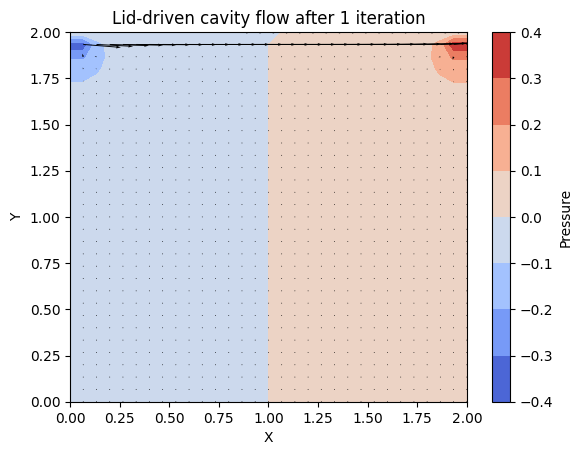

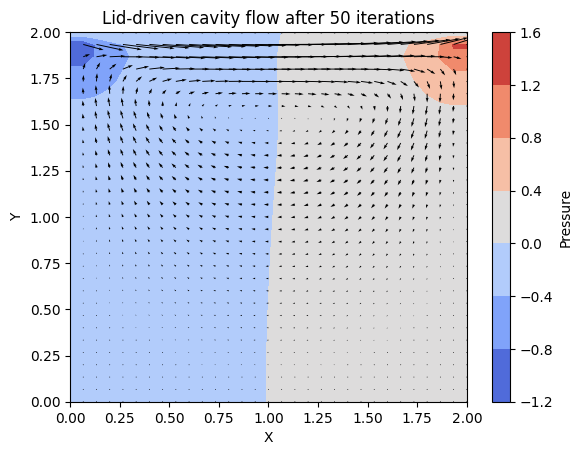

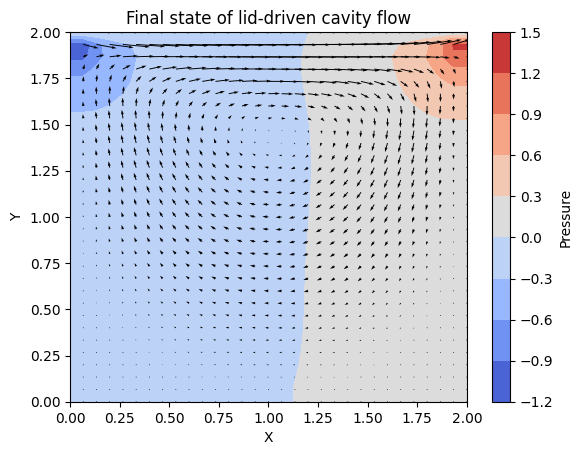

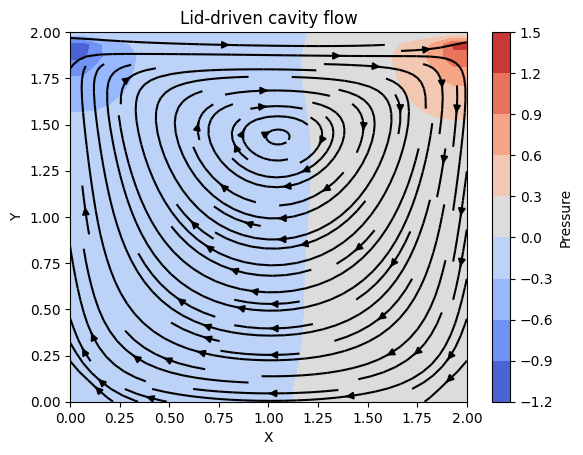

In [12]:
# Define the physical situation of a lid-driven cavity flow
physical_problem_cavity = cf.Cavity_flow(velocity=1, side="top")

# instantiate the system
system_cavity = cf.System(xBegin=0, xEnd=2, nCellsX=30, 
                          yBegin=0, yEnd=2, nCellsY=30, 
                          viscosity=0.1, density=1, 
                          physical_problem=physical_problem_cavity)

# solve the system
u_cavity, v_cavity, p_cavity = system_cavity.solve(dt=0.01, t_end=5, history=True)

# plot the results
fig0 = system_cavity.contourfigure(u_cavity[1], v_cavity[1], p_cavity[1], 
                                  cmap="coolwarm", 
                                  title="Lid-driven cavity flow after 1 iteration")
fig50 = system_cavity.contourfigure(u_cavity[50], v_cavity[50], p_cavity[50], 
                                  cmap="coolwarm", 
                                  title="Lid-driven cavity flow after 50 iterations")
fig250 = system_cavity.contourfigure(u_cavity[251], v_cavity[251], p_cavity[251], 
                                  cmap="coolwarm", 
                                  title="Final state of lid-driven cavity flow")
fig_streamline = system_cavity.contourfigure(u_cavity[251], v_cavity[251], p_cavity[251], 
                                  cmap="coolwarm", velocity="streamline",
                                  title="Lid-driven cavity flow")
fig0.show()
fig50.show()
fig250.show()
fig_streamline.show()

## Pipe flow

In this section, the flow of an incompressible fluid in a pipe is simulated.\
Dirichlet boundary conditions are used for the velocity at the left side of the domain.\
Neumann boundary conditions are used on the right side since the domain is assumed to be large enough that the velocity is not changing at the right side of the domain.\
At the bottom and top edge of the pipe the no-slip condition is applied, therefore Dirichlet boundary conditions are used for the velocity.\
Neumann boundary conditions are applied for the pressure at every side.\
The results were achieved on a domain of $(x,y) = [0,10] \times [0,2]$ with 100 grid points in x-direction and 20 grid points in y-direction. $0.1 [\operatorname{cSt}]$ is used for the kinematic viscosity and $1 [\frac{\operatorname{kg}}{\operatorname{mm}^3}]$ for the density. Furthermore, an inflow of $5 [\frac{\operatorname{mm}}{\operatorname{s}}]$ is applied.\

C:\Users\janha\AppData\Local\Temp\ipykernel_19444\1241532211.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_1.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\1241532211.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_final.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\1241532211.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_final_pressure.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\1241532211.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_final_velocity.show()


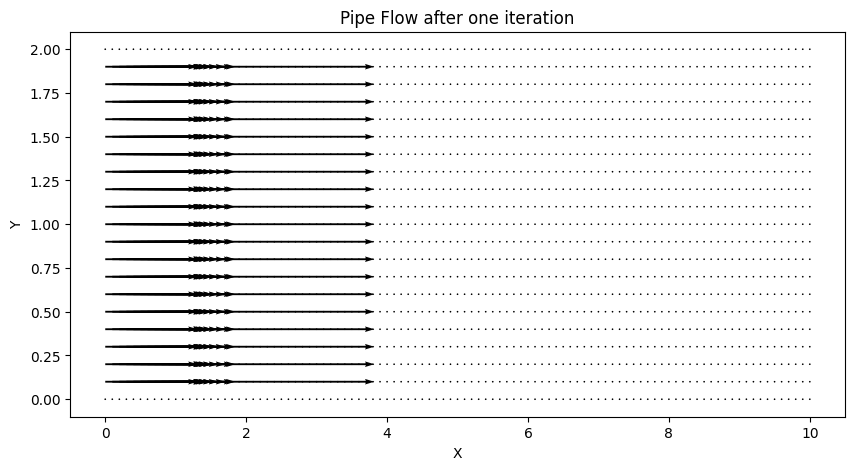

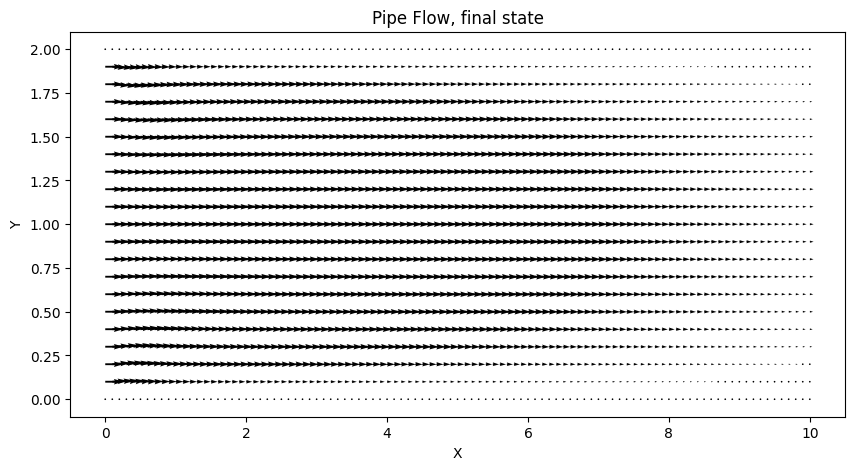

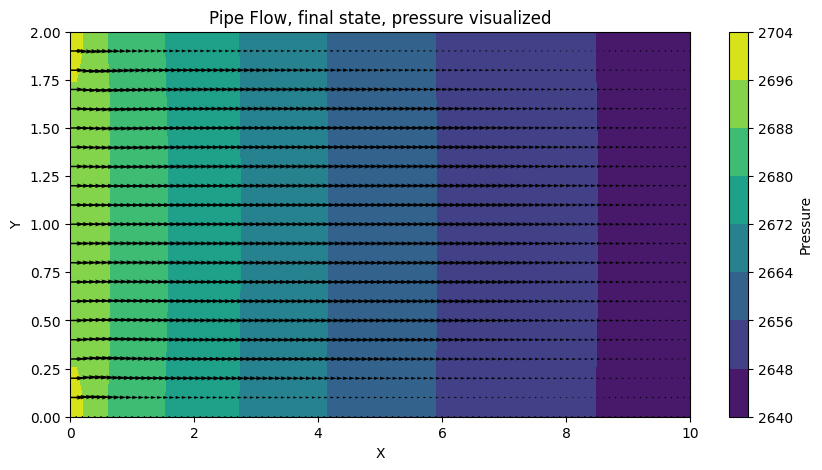

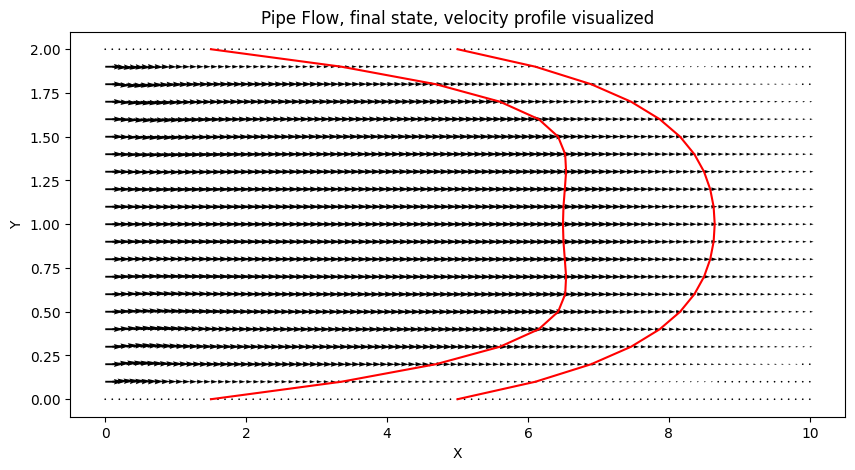

In [13]:
# Define the physical situation of a pipe flow
physical_problem_pipe = cf.Pipe_flow(u_left=5)

# instantiate the system
system_pipe = cf.System(xBegin=0, xEnd=10, nCellsX=100,
                        yBegin=0, yEnd=2, nCellsY=20, 
                        viscosity=0.1, density=1,
                        physical_problem=physical_problem_pipe)

# solve the system
u_pipe, v_pipe, p_pipe = system_pipe.solve(dt=0.01, t_end=5, 
                                           time_update="Runge_Kutta_4", adapt_dt = 0.5, 
                                           history=True)

# visualize the results
fig_1 = system_pipe.contourfigure(u_pipe[1], v_pipe[1], p_pipe[1],
                                  contour=False,
                                  figsize=(10,5),
                                  title="Pipe Flow after one iteration")
fig_final = system_pipe.contourfigure(u_pipe[-1], v_pipe[-1], p_pipe[-1],
                                      contour=False,
                                      title="Pipe Flow, final state",
                                      figsize=(10,5))
fig_final_pressure = system_pipe.contourfigure(u_pipe[-1], v_pipe[-1], p_pipe[-1],
                                               contour=True,
                                               title="Pipe Flow, final state, pressure visualized",
                                               figsize=(10,5))
fig_final_velocity = system_pipe.contourfigure(u_pipe[-1], v_pipe[-1], p_pipe[-1],
                                               contour=False,
                                               velocity_profile = [15, 50],
                                               title="Pipe Flow, final state, velocity profile visualized",
                                               figsize=(10,5))
fig_1.show()
fig_final.show()
fig_final_pressure.show()
fig_final_velocity.show()

## Pipe flow with a backward-facing step

This test case is similar to the one above. However, a backward-facing step is inserted inside the domain.\
As above, Dirichlet boundary conditions are used at the left edge of the domain for the velocities.\
Neumann boundary conditions are used at the right side and the no-slip condition is applied at the bottom and top edge.\
For the pressure, there are used Neumann boundary conditions on each side of the domain. Both, the velocity and pressure, inside the step are set to zero.\
The shown results below were achieved on a domain $(x,y) = [0,15] \times [0,5]$ with 200 grid points in x-direction and 100 grid-points in y-direction.\
The step ends at $x=4,5 \operatorname{mm}$ and $y=2,0 \operatorname{mm}$. $0.01 [\operatorname{cSt}]$ were used for the kinematic viscosity and $1 [\frac{\operatorname{kg}}{\operatorname{mm}^3}]$ for the density with an inflow velocity of $5 [\frac{\operatorname{mm}}{\operatorname{s}}]$.

In [14]:
# defining the pipe with a backward-facing step
physical_problem_pipe_step = cf.Pipe_with_a_backward_facing_step(x_step_End=60, y_step_End=40, u_left=8)

# instanciating the system
system_pipe_step = cf.System(xBegin=0, xEnd=15, nCellsX=200,
                             yBegin=0, yEnd=5, nCellsY=100,
                             viscosity=0.1, density=1,
                             physical_problem=physical_problem_pipe_step)

# solving the system
u_pipe_step, v_pipe_step, p_pipe_step = system_pipe_step.solve(dt=0.01, t_end=1,
                                                               n_iteration_pressure_poisson = 50,
                                                               adapt_dt = 0.5,
                                                               history=True)

# visualizing the results
fig_final = system_pipe_step.contourfigure(u_pipe_step[-1], v_pipe_step[-1], p_pipe_step[-1], 
                                           contour=False, velocity="streamline",
                                           figsize=(10,5),
                                           title="Pipe with a backward-facing step, final state")
fig_final_pressure = system_pipe_step.contourfigure(u_pipe_step[-1], v_pipe_step[-1], p_pipe_step[-1], 
                                                    contour=True, velocity="streamline",
                                                    figsize=(10,5),
                                                    title="Pipe with a backward-facing step, final state")
fig_final_velocity = system_pipe_step.contourfigure(u_pipe_step[-1], v_pipe_step[-1], p_pipe_step[-1], 
                                                    contour=False, velocity="streamline",
                                                    velocity_profile = [50, 130, 180],
                                                    figsize=(10,5),
                                                    title="Pipe with a backward-facing step, final state")
fig_final.show()
fig_final_pressure.show()
fig_final_velocity.show()

C:\Users\janha\AppData\Local\Temp\ipykernel_19444\3839982951.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_final.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\3839982951.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_final_pressure.show()
C:\Users\janha\AppData\Local\Temp\ipykernel_19444\3839982951.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_final_velocity.show()


### Increasing the Reyonlds number

In [15]:
# defining the step with an increased Reynolds number
physical_problem_pipe_step = cf.Pipe_with_a_backward_facing_step(x_step_End=60, y_step_End=40, u_left=20)

# instanciating the system with the new step
system_pipe_step = cf.System(xBegin=0, xEnd=15, nCellsX=200,
                             yBegin=0, yEnd=5, nCellsY=100,
                             viscosity=0.1, density=1,
                             physical_problem=physical_problem_pipe_step)

# solving the system
u_high_Reynolds, v_high_Reynolds, p_high_Reynolds = system_pipe_step.solve(dt=0.01, t_end=1,
                                                                           n_iteration_pressure_poisson = 50,
                                                                           adapt_dt = 0.5,
                                                                           history=False)

# visualizing the results
high_Reynolds = system_pipe_step.contourfigure(u=u_high_Reynolds, v=v_high_Reynolds, p=p_high_Reynolds, 
                                               contour=False, velocity="streamline",
                                               figsize=(10,5),
                                               title="Pipe with a backward-facing step, high Reynolds number, final state")

# Discussion
After reaching results, the accuracy of these results is of high interest.\
It is interesting if the results make sense, from a physical point of view, and if they are close to the analytical solutions.\
This discussion analyses the Cavity flow and the pipe with a backward-facing step qualitatively.\
The pipe flow is analysed qualitatively and quantitatively.

## Lid-driven cavity-flow

**Expected Results:**\
In the simulated case, the lid is moving on top of the domain, so the velocity profile across the vertical centerline is expected to be parabolic.\
Furthermore, the flow is expected to be symmetric along the centerlines.\
Next, the streamlines are expected to be clockwise.\
Additionally, the pressure is expected to be higher on the right side of the domain and lower on the left side. The maximum is expected at the top right edge and the minimum at the top left edge.\
**Verification of the Results:**\
In the simulated case, all the requirements for the pressure and velocity field over the domain are satisfied, qualitatively, as it can be seen below.

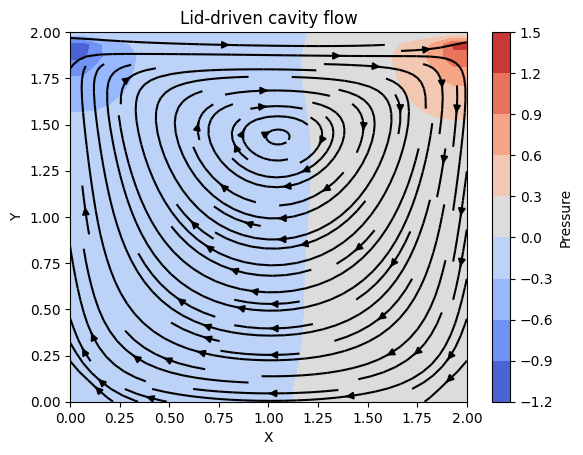

In [16]:
fig_streamline

For now, it is interesting how many iterations are needed till convergence for different discretizations.

In [17]:
# instantiating the different grid sizes
grids = [3, 30, 300]
cavity_iterations = []

# instantiating the lid driven cavity problem
physical_problem_cavity = cf.Cavity_flow(1, "top")

# iterating over the grid sizes to get the number of iterations
for n in grids:
    system_cavity = cf.System(xBegin=0, xEnd=100, nCellsX=n, 
                              yBegin=0, yEnd=100, nCellsY=n, 
                              viscosity=0.1, density=1, 
                              physical_problem=physical_problem_cavity)
    u_cavity_cur, v_cavity_cur, p_cavity_cur = system_cavity.solve(dt=0.001, t_end=500, 
                                                                   residual=0.001, 
                                                                   residual_pressure_poisson=0.001, n_iteration_pressure_poisson=1000, 
                                                                   history=True, adapt_dt=0.8)
    cavity_iterations.append(len(u_cavity_cur))
    
# visualizing the convergence
plt.loglog(grids, cavity_iterations, 'o-', label="cavity iterations")
xref = [10, 100]
yref1 = [10**2, 10**3]
yref2 = [10**2, 10**4]
plt.loglog(xref, yref2, 'k--', label="reference order 2")
plt.legend()
plt.title("Convergence of cavity iterations")
plt.xlabel("Number of grid points")
plt.ylabel("Number of iterations")

Convergence reached after 0.002seconds, simulation stopped
Convergence reached after 0.1300000000000001seconds, simulation stopped
Convergence reached after 6.603999999999495seconds, simulation stopped


Text(0, 0.5, 'Number of iterations')

As one can see, the number of needed iterations till convergence is of order two. Therefore, the method needs increasing iterations to converge for a finer discretization.

## Pipe flow

In the next step the results from the pipe flow are verified.\
**Expected Results:**\
For a pipe flow the Hagen-Poiseuille velocity profile 
\begin{align*}
    u_{\operatorname{max}} &= -\frac{R^2}{4\eta}\frac{dp}{dx} \\
    u(r) &= u_{\operatorname{max}} \cdot \left( 1-\left(\frac{r}{R}\right)^2\right)
\end{align*}
is the expected result.\
**Verification of the Results:**\
The analytical solution, blue line, and the numerical solution, red line, can be seen below.

In [18]:
# where the velocity profile is evaluated
index = 50

# Defining parameter
DYNAMIC_VISCOSITY = 0.1 # kinematic viscosity * density
R = 1

# analytical solution for the velocity profile
def Hagen_Poiseuille(r:np.array,
                     R:float, 
                     viscosity:float, 
                     p:np.ndarray, 
                     system:cf.System,
                     index:tuple):
    """
    Computes the Hagen-Poiseuille velocity profile

    Parameters
    ----------
    r : np.array
        Radius to compute the velocity profile on
    R : float
        Radius of the pipe
    viscosity : float
        viscosity of the fluid
    p : np.ndarray
        pressure
    system : cf.System
        system which has solved the numerical results
    index : tuple
        index where to calculate the velocity profile

    Returns
    -------
    np.ndarray
        Analytical solution
    """
    dpdx = system.grid.central_fd(p, 0, 1)
    v_max = -(R**2)/(4*viscosity)*dpdx[index[0],index[1]]
    
    return v_max * (1-(r/R)**2)

# visualize the numerical solution
plt.figure(figsize=(10,5))
plt.plot(index * system_pipe.grid.get_dx() + u_pipe[-1][:,index], system_pipe.grid.get_y()[:,index], color="red", label="Numerical solution")

# visualize the analytical solution
r_top = np.linspace(0, 1, 11)
r_bottom = np.linspace(1, 0, 11)
Hagen_bot = Hagen_Poiseuille(r_bottom, R, DYNAMIC_VISCOSITY, p_pipe[-1], system_pipe, (11,index))
Hagen_top = Hagen_Poiseuille(r_top, R, DYNAMIC_VISCOSITY, p_pipe[-1], system_pipe, (11,index))
plt.plot(index * system_pipe.grid.get_dx() + Hagen_top, system_pipe.grid.get_y()[10:,index], color="blue", label="Analytical solution")
plt.plot(index * system_pipe.grid.get_dx() + Hagen_bot, system_pipe.grid.get_y()[:11,index], color="blue")
plt.title("Velocity profile at x = 5")
plt.legend()

It is easy to verify that these results are not very good. The reason for this is the pressure correction.\
 A Poisson equation is solved in each iteration to get the value for the pressure. This iterative method, the Jacobi solver, is a huge drawback of the used method since it takes many iterations to get a really good approximation for the pressure field on a fine grid.\
 However, this increases the compute time exponentially since a Jacobi-solver needs exponentially more iterations to converge for a finer grid.\
Therefore, the accuracy for the velocity, when the pressure is known, is of interest.\
In this case, it is not needed to solve the Poisson equation in each time step and the accuracy of the whole algorithm, besides the Jacobi solver, can be verified.

![title](img/Convergence_pressure_driven_pipe_relative_error.png)

It can be seen that the results for the velocity are much better when the pressure is known.\
For such a case, the results are very accurate. The used implementation seems not to converge very well.\
Although the convergence is not even of order one, the results are very close to the analytical solution. With a very coarse discretization the relative error is already very small.

## Pipe flow with a backward-facing step
**Expected Results:**\
On top of the step and far enough behind the step the Hagen-Poiseuille velocity profile is expected.\
Directly behind the step vortexes are expected to build. For a high Reynolds number, those vortexes are also expected on the top edge of the domain, behind the step.\
**Verification of the Results:**\
As one can see in the results for the pipe with a backward-facing step, the Hagen-Poiseuille velocity profile is about to build on top of the step.\
However, it is not fully retrieved because the step size is not long enough. The same can be seen behind the step. The velocity profile is not fully retrieved but is about to build.\
Furthermore, the vortexes can be seen behind the step. One can also see the expected vortexes on the top edge of the domain for a high Reynolds number.\
Therefore, the results for the pipe with a backward-facing step can be verified qualitatively. 

# Conclusion

To sum up, Chorin's projection method is a method that is working. The results are very close to the analytical results, if enough iterations are used.\
However, the need to solve a Poisson equation in each time step is a major drawback of this method.\
The result of this is a very slow algorithm for a fine discretization. In such a case, another method as the SIMPLE algorithm, introduced in the introduction, may perform better.

Besides the numerical accuracy the goal to provide an easy-to-use solver for the incompressible Navier-Stokes equation was reached, as it can be seen above.\
One needs to install cflowpy, which is doable with pip and then it is possible to start simulations. To start such a simulation it is only needed to define the numerical domain, the values for the Dirichlet boundary conditions, the kinematic viscosity and the density of the fluid.\
However, it is also possible to define new classes in ``PhysicalProblem`` to simulate different and even more advanced problems.\
Therefore, cflowpy achieves the goal to provide an easy to use and extendable Python interface for flow simulations, using Chorin's projection method.

# Outlook

The cflowpy Python package can simulate the flow of an incompressible fluid, to predict the velocity and pressure fields, by solving the incompressible Navier-Stokes equation with a fractional step algorithm.\
Although it is an easy-to-use Python interface for flow simulation, they are a few things that can be improved in future developments to make cflowpy more flexible and faster.\
In the future, the user should get the possibility to define the boundary- and initial conditions more flexible without the need to use pre-defined classes, as it is done now.\
Furthermore, the coordinate system can be extended to curvilinear coordinates to simulate more complex geometries.\
Additionally, performance wise it would make sense to call a low-level programming language, instead of only using Python. Doing this, some part of the code would get compiled and the compute time of a simulation would decrease.\
This enables the possibility to simulate finer discretizations without an unreasonable high compute time.\
However, yet there is used a lot of vectorization and numpy operations to keep the compute time as low as possible while using Python as the programming language.

# References
- A. J. Chorin. “Numerical solution of the Navier-Stokes equations”. In: Mathematics of
Computation (1968).
-  Liu Jian-Guo E. Weinan. Projection Method I :Convergence and Numerical Boundary Lay-
ers. p.6-p.11. url:[https://web.math.princeton.edu/~weinan/papers/cfd2.pdf](https://web.math.princeton.edu/~weinan/papers/cfd2.pdf)
(visited on 08/05/2023).
-  Jan Habscheid. cflowpy. [https://git.rwth-aachen.de/Jan.Habscheid/cflowpy](https://git.rwth-aachen.de/Jan.Habscheid/cflowpy).
(commit: bea0f490bef12a848f3d48389bf5a2f6b5ac877c). 2023.